# Initial thoughts 
### Things done well:
- This was my first proper ML project where I achieved a high accuracy compared to my peers
- I spent a high amount of time on the project and it really started my passion for ML#
- I learnt many skills such as handling different types of data, data processing, trying and improving different models, tf-idf, dimensionality reduction

### Improvements:
- I spent most of the time trying to increasing my training score as high as possible which is bad as this clearly leads to overfitting
- My inital data exploration and subsquent visualisations were poor
- I used a bazaar versioning system rather than Jupyter notebooks
- I didnt structure my work very well and the explainations were more a stream of thoughts. 

# We start again

## Frame the problem
The problem is that we want to be able to take a tweet about a live news story and give a classification as to whether the contents of the message is real or fake. Such a system would be used by a news company to increase their confidence that any tweets they post in their articles are geniune. 

A current system would require a journalist to go through each individual tweet and make a decision themselves. With this system a list of refined real tweets could be presented to the journalist.

It is a supervised offline classification problem where the perfromance is measured by F1 score - the higher the score the more we can trust that a tweet classified as real is a genuine source that can be included in a report

I do have my previous system that I could reuse but I won't as in this project I am not looking for high performance but rather a well strucuted notebook with insights and graphs that give reason to my decision making. The only expertise available is my own real world experince of using twitter and seeing how fake tweets are often used by trolls. 

The minimum perfromance needed to add value is unknown, if we can produce a system that 9/10 gives a correct prediction then this is likely to be useful. 

The project contains tweet text data for which there are similiar projects avaible that could be looked at for inspiration.


## Get the data

Data is provided as part of the coursework. The data is real world tweets collected about Hurricane Sandy that hit the US in late 2012

## Explore the data

In [25]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [26]:
data_raw = pd.read_csv("data/mediaeval-2015-trainingset.txt", sep='\t')

In [27]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


Straight away we can see all of the columns and that it appears we do not have any null vlaues. We have two int columns (tweetId and userId) and then 5 object columns. Both int columns are Id's so there is limited (if any) data inspection we can do here. We could look for duplicates

In [28]:
num_attribs = ['tweetId', 'userId']
obj_attribs = [x for x in data_raw.columns if x not in num_attribs]

In [29]:
users_with_more = data_raw['userId'].value_counts().where(lambda x : x > 1).dropna()
print(users_with_more)

139189262     16.0
834560797     10.0
357078809      9.0
89221442       8.0
2623669827     8.0
              ... 
392302245      2.0
464045416      2.0
339187255      2.0
244344102      2.0
31322164       2.0
Name: userId, Length: 551, dtype: float64


There are 551 users that appear more than once but will not include 'userId' as a training attribute. This makes sense as this could lead to a model overfitting in the real world. For instance if the model learns that one users tweets are always real and then in practice the system has a fake input from this user it could get passed to the journalist and defeat the goal of the system. However, it could be argued that identifying accounts that are reputable sources or not could be used, this would have to be something to go back to the product owner to discuss. 

We will also look at tweetId in a similar way

In [30]:
tweets_with_more = data_raw['tweetId'].value_counts().where(lambda x : x > 1).dropna()
tweetIds = tweets_with_more.keys().tolist()
print(tweets_with_more)
print(tweetIds)

264736470089216000    2.0
263351427320131584    2.0
Name: tweetId, dtype: float64
[264736470089216000, 263351427320131584]


In [31]:
print(data_raw[data_raw['tweetId'].isin(tweetIds)])

                  tweetId                                          tweetText  \
2439   264736470089216000  Lower Manhattan's power is gone. Pretty eerie ...   
7744   263351427320131584            Ground Zero #Sandy http://t.co/KA1jNv3I   
7821   263351427320131584            Ground Zero #Sandy http://t.co/KA1jNv3I   
11947  264736470089216000  Lower Manhattan's power is gone. Pretty eerie ...   

         userId      imageId(s)      username                       timestamp  \
2439    2675041  sandyB_fake_11         cDima  Sat Nov 03 14:31:07 +0000 2012   
7744   15933769  sandyA_real_04  AngelaYvonne  Tue Oct 30 18:47:27 +0000 2012   
7821   15933769  sandyA_real_04  AngelaYvonne  Tue Oct 30 18:47:27 +0000 2012   
11947   2675041  sandyB_real_54         cDima  Sat Nov 03 14:31:07 +0000 2012   

      label  
2439   fake  
7744   real  
7821   real  
11947  real  


The 'Ground zero' tweets are identical with both having 'real' labels. However, for the 'Lower Manhattan's' tweets one is real and one is fake; the only difference is their imageId(s). We can gain insight here that some of the imageId's actually contain the correct label for the tweet. We can make a feature out of this.

In [32]:
data_raw = data_raw.drop_duplicates()
print(data_raw[data_raw['tweetId'].isin(tweetIds)])

                  tweetId                                          tweetText  \
2439   264736470089216000  Lower Manhattan's power is gone. Pretty eerie ...   
7744   263351427320131584            Ground Zero #Sandy http://t.co/KA1jNv3I   
11947  264736470089216000  Lower Manhattan's power is gone. Pretty eerie ...   

         userId      imageId(s)      username                       timestamp  \
2439    2675041  sandyB_fake_11         cDima  Sat Nov 03 14:31:07 +0000 2012   
7744   15933769  sandyA_real_04  AngelaYvonne  Tue Oct 30 18:47:27 +0000 2012   
11947   2675041  sandyB_real_54         cDima  Sat Nov 03 14:31:07 +0000 2012   

      label  
2439   fake  
7744   real  
11947  real  


We have removed the one duplicate entry and let the two tweets with different imageId(s). It would be useful to look at the users with multiple tweets to see if they tend to be true or fake tweets

In [33]:
data_raw.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


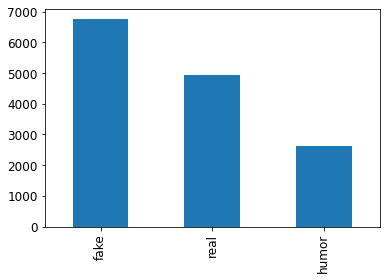

In [34]:
import seaborn as sns

data_raw['label'].value_counts().plot(kind='bar')

<AxesSubplot:>

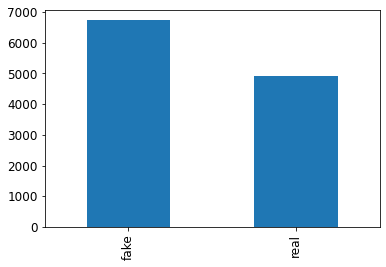

In [36]:
data_raw = data_raw.drop(data_raw[data_raw['label'] == 'humor'].index)
data_raw['label'].value_counts().plot(kind='bar')

Removed the 'humor' label as from the project specification we do not want to predict this label so the entries with this label have been removed. We can see from the counts of the fake and real labels that we do have a skewed dataset. This would be something to look into (TODO)

<AxesSubplot:xlabel='username', ylabel='count'>

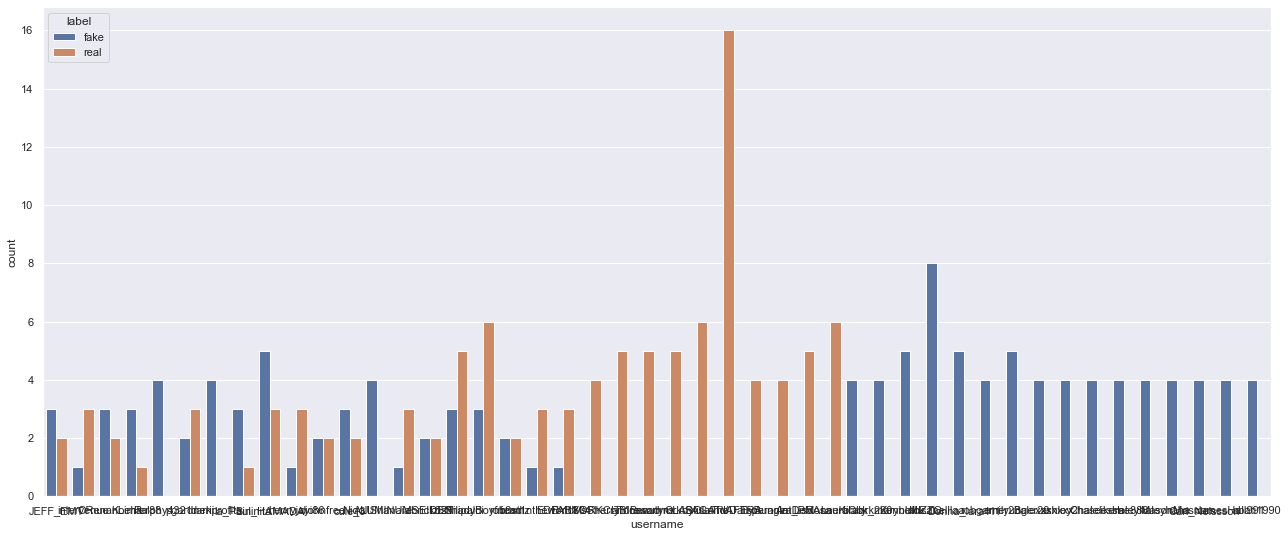

In [65]:
freq_users = data_raw.groupby('username').filter(lambda x : len(x) > 3)
freq_users.head()


sns.set(rc={'figure.figsize':(22,9)})
sns.countplot(x="username", hue='label', data=freq_users)

The userId's arent visible but we can see that some users (those with more than tweets in the dataset) do tweet completely either fake or real tweets but there are mixed accounts. I'm undecided if we should keep username in the dataset, this would be something to go back to the product owners on. We can drop userId as, by definition, it is purely a unique id for that user. We can also drop 'tweetId' as from context of the problem the Id of a tweet has no relation to its context and therefore if it is real or not. 

In [67]:
data_raw = data_raw.drop(columns=['tweetId', 'userId'])
print(data_raw.columns)

Index(['tweetText', 'imageId(s)', 'username', 'timestamp', 'label'], dtype='object')
